# CS 283 Homework assignment #4: Glow

In this homework, we are going to explore the [Glow model](https://openai.com/blog/glow/).
It is a flow-based model, so before you start — make sure that you understand the corresponding lectures well.

We are going to do 3 things:

- [1 pts] train a Glow model on MNIST
- [8 pts] implement a simple block-diagonal layer to hone our understanding of flow-based models
- [1 pts] explore how reasonable the reversibility of Glow is

There are also 2 bonus points:
- [1 bonus pts] run Glow on Celeba 64x64
- [1 bonus pts] do a simple ablation for the block-diagonal layer

What you can and what you cannot do:
- You are free to use whatever code/information you find online, but you **must specify the sources** (otherwise we'll consider that you copied some other student's work)
- You are **not** allowed to put your solution online or share it with other students
- You can change the training hyperparameters if you like

To do this assignment you will need:
- `pytorch3.6+`
- `torch>=1.5`
- `torchvision>=0.4.0`
- `hydra>=1.0.4`
- `tqdm`, `numpy`, `scipy`, `pillow` and other standard libraries
- a GPU card (we used 2080 Ti to design this assignment)

What you should submit:
- A zip-archive named `FIRSTNAME_LASTNAME_CS283_HW4.zip` with this solved notebook and the corresponding images. You are not supposed to change `train.py` and `model.py`, but if you do — you must submit them as well. You will be deduced 0.5 points if your submission is not named properly.
- **Very important**: your notebook must be reproducible. I.e. when one hits `Run All Cells` button on your submitted notebook — it should execute without runtime errors (the only exception is if only some libraries are not found) and provide the same results that you report.
- Please, have mercy on us and do not use more than 11GB GPU memory since it might become a bit harder for us to evaluate your homework. You can use more compute for Celeba 64x64, but the main part can be done under 11 GB in a reasonable time.

------
For any questions/errors, please contact Kilichbek Haydarov in the `#cs283` slack channel.

____
Credit: the base implementation of Glow in this homework assignment is based on the [Glow implementation by @rosinality](https://github.com/rosinality/glow-pytorch/blob/master/model.py)

In [1]:
!pip install omegaconf

## Part 1 (1 points + 1 bonus point): training the Glow model

In [2]:
import os
from typing import List, Callable, Optional, Any

import torch
from omegaconf import OmegaConf
from torchvision import transforms
from omegaconf import OmegaConf
from torchvision.datasets import MNIST

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = OmegaConf.create({
    'batch_size': 32,
    'num_iters': 50000,                 # Number of iterations
    'num_flows': 4,                     # Number of flows in each block
    'num_blocks': 4,                    # Number of blocks
    'no_lu': False,                     # Disable LU decomposition
    'affine': False,                    # Affine coupling instead of additive
    'num_bits': 1,                      # Number of bits for the output
    'lr': 1e-4,                         # Learning rate
    'img_size': 32,                     # Image resolution
    'img_num_channels': 1,              # Number of images channels
    'temp': 0.7,                        # Sampling temperature
    'num_samples': 20,                  # Number of samples to save
    'save_samples_freq': 1000,          # How often should we save samples?
    'save_ckpt_freq': 10000,            # How often should we save model checkpoints?
    'samples_dir': 'samples',           # Where to save samples?
    'checkpoints_dir': 'checkpoints',   # Where to save checkpoints?
})

In [3]:
from PIL import Image
from model import Glow
from train import train, infinite_dataloader
from torch import optim

transform = transforms.Compose([
    transforms.Resize(config.img_size, interpolation=Image.LANCZOS),
    transforms.CenterCrop(config.img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
dataset = MNIST('./data', train=True, download=True, transform=transform)
dataloader = infinite_dataloader(dataset, config.batch_size)
model = Glow(config.img_num_channels, config.num_flows, config.num_blocks, affine=config.affine, conv_lu=not config.no_lu)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=config.lr)
train(config, model, optimizer, dataloader, device)

/ibex/user/durdymk/conda-environments/cs283_assignment1/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/home/durdymk/CS-283-Deep-Generative-Modeling/CS283_Assignment4/coding/model.py:101: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  w_s = torch.from_numpy(w_s)
Loss: 0.76865; logP: -0.81095; logdet: 1.04230; lr: 0.0001000: 100%|██████████| 50000/50000 [43:34<00:00, 19.

Here are the samples that you should expect to see after 50k iterations (2 hours of training on 2080 Ti)

![Samples for BlockDiagonalGlow](samples_50k.jpeg "BlockDiagonalGlow")

### Exercise 1.1 (1 points): answer the following questions:
- What is good about the Glow model?
- What is bad about the Glow model?

> TODO: you answer here

Good thing about Glow model is that it can compute the exact likelihood of a given data point, which is useful in applications such as density estimation and anomaly detection. Also, the glow model is an invertible generative model, meaning it can map a data point to its latent representation and back, enabling applications such as image editing and style transfer. 

Bad thing about Glow is, flow-based models are more expensive to train compared to autoregressive models and VAEs. Also, smaller depth models do not perform as well in learning long-range dependencies.

### Exercise 1.2 (1 bonus point): train a larger version of the model on Celeba 64x64 for more iterations and report the results

## Part 2 (8 points + 1 bonus point): Block-diagonal layer

In this section, you are asked to implement a simple block-diagonal weight layer. I.e. it is the same as conv1x1, but its weight matrix is structured as a block-diagonal matrix where **each block has a size of just 2x2**:
$$
W = \begin{bmatrix}
w_{1,1} & w_{1,2} & & & & & \\
w_{2,1} & w_{2,2} & & & & & \\
& & w_{3,3} & w_{3,4} & & & \\
& & w_{4,3} & w_{4,4} & & & \\
& & & & \ddots & & & \\
& & & & & w_{n-1,n-1} & w_{n-1,n}\\
& & & & & w_{n,n-1} & w_{n,n}\\
\end{bmatrix}
$$

"Empty" values in matrix $W$ are **zeros**.

*Note*: we assume that all our matrix sizes are divisible by 2.

*Note*: Just as in Glow, we consider 1x1 convolutions only (so they can be invertible), thus our weight matrix is illustrated as 2d and not 4d.

### Exercise 2.1 (1 point): answer the following questions:
1. What are the advantages of the above weight representation?
2. What are the disadvantages of the above weight representation?

> Your answers here

Advantages: Most matrix elements are zero, which means fewer parameters need to be learned. This reduces model complexity and can speed up training. 

Disadvantages: the limited weight representation of some models, where the weight matrix is restricted to a block-diagonal structure with 2x2 blocks, may not be able to capture complex patterns or interactions that span across multiple blocks. This may limit the model's expressiveness.

### Exercise 2.2 (5 points): implement the BlockDiagonalConv2d layer

Above, you were provided with the description of the block-diagonal Conv2d layer. Now, you are asked to implement it. I.e. you should implement a reversible 1x1 Conv2d layer which weight matrix is structure as above: as a block-diagonal matrix with 2x2 blocks. This layer should also compute the logarithm of the absolute value of the determinant of the jacobian ("LADJ") at a given point during the forward pass — see `model.py` to figure out the interface.

Rules:
- You are **not** allowed to store a full weight matrix: find a convenient way to store only $2n$ values instead of $n\times n$ matrix. For example, for a diagonal matrix we could store only one vector of size $n$ instead of a $n \times n$ matrix.
- You are **not** allowed to use functions like `torch.slogdet`/`torch.inverse`/`torch.det`/`torch.logdet` for this implementation
- You are not allowed to unpack your $2n$ values into $n\times n$ matrix — otherwise it will be meaningless to have this compressed representation. For example, a multiplication of a diagonal matrix $A = \text{diag}(a_1, ..., a_n$ with a vector $x$ can be computed as an element-wise multiplication of two vectors: $x$ and $a = (a_1, ..., a_n)$.

Note: a test for reversibility below is useful, but it does not check the correctness of your ladj computation. So be mindful about your ladj implementation.

In [5]:
from typing import Tuple

import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F
from math import log, pi, exp
import numpy as np
from scipy import linalg as la

from model import Flow, Block, Glow


class BlockDiagonalConv2d(nn.Module):
    """
    A 1x1 Conv2d layer with 2x2 block-diagonal weight matrix as described above
    """
    def __init__(self, in_channel: int):
        super().__init__()

        # TODO: Define the parameters
        # Hint: think about how we should store the weight matrix in such a way
        # that we can compute all the forward/ladj/reverse operations more efficiently
        # Hint: we can store it just as 2 vectors of length `in_channel`: for upper values
        # of each block and for lower values of each block. You can also store tham as [n/2, 2, 2]
        # Hint: what initialization should we use for them?
        self.weight = nn.Parameter(torch.rand(in_channel//2, 2, 2))
        self.in_channel = in_channel

    def forward(self, x) -> Tuple[Tensor, Tensor]:
        # TODO: implement the forward pass
        # Hint: since our matrix is so sparse and well-structured,
        # we can compute it much more efficiently "manually"
        # Hint: see layers in model.py and check the lectures if you
        # are confused about what you are asked to do
        W = torch.zeros((self.in_channel, self.in_channel), dtype=x.dtype).to(x.device)
        det = 1.0
        for i in range(0, self.in_channel, 2):
            a, b, c, d = self.weight[i // 2].flatten()
            det *= (a * d - b * c)
            W[i:i + 2, i:i + 2] = self.weight[i // 2]
        out = F.conv2d(x, W.unsqueeze(2).unsqueeze(3))
        logdet = x.shape[2] * x.shape[3] * torch.sum(torch.log(torch.abs(det)))
        return out, logdet
    
    def reverse(self, y: Tensor) -> Tensor:
        # TODO: implement the reverse forward pass for this block
        W_inv = torch.zeros((self.in_channel, self.in_channel), dtype=y.dtype).to(y.device)
        for i in range(0, self.in_channel, 2):
            a, b, c, d = self.weight[i // 2].flatten()
            det = (a * d - b * c) + 1e-15 #loss was going to nan without adding this, maybe due to the next line div by zero possibility
            inv_det = (1 / det).to(x.device)
            block_inv = inv_det * torch.tensor([[d, -b], [-c, a]]).to(y.device)
            W_inv[i:i + 2, i:i + 2] = block_inv
        out = F.conv2d(y, W_inv.unsqueeze(2).unsqueeze(3))
        return out
    
# A simple test for reversibility
batch_size, c = 11, 128
l = BlockDiagonalConv2d(c).double()
x = torch.randn(batch_size, c, 64, 64).double()
y, _ = l(x)
x_rec = l.reverse(y)

assert torch.allclose(x_rec, x, atol=1e-8)

### Exercise 2.3 (1.5 points): implement the shuffling layer

Having just a BlockDiagonalConv2d would limit the interaction between channels to just inside-blocks interactions.
This can be solved by shuffling the elements before feeding them into `BlockDiagonalConv2d`.

In this exercise, you are asked to implement a layer $S(x)$, which receives $x \in \mathbb{R}^{n \times c \times h \times w}$ and shuffles its channels with a fixed random permutation.
This would allow us to stack several BlockDiagonalConv2d layers in such a way that different neurons will be interecting with many neurons and not just the neurons inside their tiny $2 \times 2$ block.

In [6]:
class ShufflingLayer(nn.Module):
    def __init__(self, in_channel: int):
        super().__init__()
        
        self.register_buffer('permutation', torch.from_numpy(np.random.permutation(in_channel)))
        
        # TODO: compute the inverse of the permutation,
        # i.e. an array which puts elements back in place
        self.register_buffer('permutation', torch.from_numpy(np.random.permutation(in_channel)))

        inv_perm = torch.zeros_like(self.permutation)
        for i, p in enumerate(self.permutation):
            inv_perm[p] = i
        self.register_buffer('perm_inv', inv_perm )
        
    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        # TODO: perform the forward pass
        y = x[:, self.permutation]
        ladj = 0.0
        
        return y, ladj
    
    def reverse(self, y: Tensor) -> Tensor:
        # TODO: perform the reverse forward pass
        x = y[:, self.perm_inv]
        return x
    

# A simple test for reversibility
batch_size, c = 11, 128
l = ShufflingLayer(c).double()
x = torch.randn(batch_size, c, 64, 64).double()
y, _ = l(x)
x_rec = l.reverse(y)

assert torch.allclose(x_rec, x, atol=1e-8)

Putting everything together

In [7]:
class ShuffledBlockDiagonalConv2d(nn.Module):
    def __init__(self, in_channel: int):
        super().__init__()
        
        self.shuffle = ShufflingLayer(in_channel)
        self.conv = BlockDiagonalConv2d(in_channel)
        
    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        x, ladj1 = self.shuffle(x)
        x, ladj2 = self.conv(x)
        
        return x, ladj1 + ladj2
    
    def reverse(self, y: Tensor) -> Tensor:
        return self.shuffle.reverse(self.conv.reverse(y))
    
    
# A simple test for reversibility
batch_size, c = 11, 128
l = ShuffledBlockDiagonalConv2d(c).double()
x = torch.randn(batch_size, c, 64, 64).double()
y, _ = l(x)
x_rec = l.reverse(y)

assert torch.allclose(x_rec, x, atol=1e-8)

In [8]:
from model import ActNorm, AffineCoupling, ZeroConv2d

class BlockDiagonalFlow(Flow):
    def __init__(self, in_channel, affine=True, conv_lu=True):
        nn.Module.__init__(self)

        self.actnorm = ActNorm(in_channel)
        self.invconv = ShuffledBlockDiagonalConv2d(in_channel)
        self.coupling = AffineCoupling(in_channel, affine=affine)


class BlockDiagonalGlowBlock(Block):
    def __init__(self, in_channel, n_flow, split=True, affine=True, conv_lu=True):
        nn.Module.__init__(self)

        squeeze_dim = in_channel * 4

        self.flows = nn.ModuleList()
        
        for i in range(n_flow):
            self.flows.append(BlockDiagonalFlow(squeeze_dim, affine=affine, conv_lu=conv_lu))

        self.split = split

        if split:
            self.prior = ZeroConv2d(in_channel * 2, in_channel * 4)
        else:
            self.prior = ZeroConv2d(in_channel * 4, in_channel * 8)


class BlockDiagonalGlow(Glow):
    def __init__(self, in_channel, n_flow, n_block, affine=True, conv_lu=True):
        nn.Module.__init__(self)

        self.blocks = nn.ModuleList()
        n_channel = in_channel
        for i in range(n_block - 1):
            self.blocks.append(BlockDiagonalGlowBlock(n_channel, n_flow, affine=affine, conv_lu=conv_lu))
            n_channel *= 2
        self.blocks.append(BlockDiagonalGlowBlock(n_channel, n_flow, split=False, affine=affine))

In [9]:
config.batch_size = 128
config.save_samples_freq = 500
config.samples_dir = "samples_block_diag"
config.checkpoints_dir = "checkpoints_block_diag"

transform = transforms.Compose([
    transforms.Resize(config.img_size, interpolation=Image.LANCZOS),
    transforms.CenterCrop(config.img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
dataset = MNIST('./data', train=True, download=True, transform=transform)
dataloader = infinite_dataloader(dataset, config.batch_size)
model = BlockDiagonalGlow(config.img_num_channels, config.num_flows, config.num_blocks, affine=config.affine, conv_lu=not config.no_lu)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=config.lr)
train(config, model, optimizer, dataloader, device)

Loss: 0.77288; logP: -0.43396; logdet: 0.66108; lr: 0.0001000: 100%|██████████| 50000/50000 [1:11:31<00:00, 11.65it/s]


Since our layer is so simple and we implemented it only to play around with the flow-based models, do not expect the results to be better than for the InvConv2d layer.
For example, here is what we got after 50k iterations of training.

![Samples for BlockDiagonalGlow](samples_50k_block_diag.jpeg "BlockDiagonalGlow")

### Exercise 2.4 (0.5 points): answer the following questions:
- Has your training speed improved? Why or why not?

> TODO: you answers here

Weight matrix of diagonal block reduce from $N \times N$ to $N/2 \times 2 \times 2$, means it should be faster training and reduced model complexity.

### Exercise 2.5 (1 bonus point): test BlockDiagonalGlow without shuffling

Run the experiment without shuffling (i.e. without using `ShuffledBlockDiagonalConv2d`) and report what the results for it are (both quantitative and qualitative). Does the training speed change?

## Part 3 (1 points): checking the reconstruction properties of our model

What is interesting about the Glow model is that it can "work" as a perfect "autoencoder" *even when it is randomly initialized*. This is due to its perfect invertibility.

### Exercise 3.1 (0.5 points): Display 10 random images with their reconstructions for a randomly initialized Glow model

- Top row: real images.
- Bottom row: reconstructions $\hat{x} = f^{-1}(f(x))$, where $f:\mathcal{X}\to\mathcal{Z}$ is our Glow model.

<!-- Here is an example of what you are supposed to get:

![Reconstructions example](./reconstructions.jpeg "Reconstructions example")
 -->
Hint: you might find `torchvision.utils.make_grid` and `torchvision.transforms.functional.to_pil_image` to be handy.

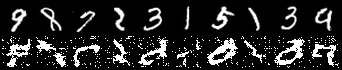

In [18]:
import random
import torchvision.transforms.functional as TVF
from torchvision.utils import make_grid

# TODO: display 10 training images and their reconstructions

from model import Glow


from PIL import Image
from model import Glow
from train import train, infinite_dataloader

config.batch_size = 10
config.samples_dir = "samples_block_diag"
config.checkpoints_dir = "block_checkpoints_block_diag"

transform = transforms.Compose([
    transforms.Resize(config.img_size, interpolation=Image.LANCZOS),
    transforms.CenterCrop(config.img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

dataset = MNIST('./data', train=True, download=True, transform=transform)
dataloader = infinite_dataloader(dataset, config.batch_size)
model = BlockDiagonalGlow(config.img_num_channels, config.num_flows, config.num_blocks, affine=config.affine, conv_lu=not config.no_lu)
model = model.to(device)

checkpoint_path = './checkpoints_block_diag/model_050000.pt'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)

real_images, _ = next(iter(dataloader))
images = real_images.to(device)
images = images * 255
images = torch.floor(images / 2 ** (8 - config.num_bits))
n_bins = 2.0 ** config.num_bits
images = images / n_bins - 0.5

with torch.no_grad():
    _, _, z_sample = model(images + torch.rand_like(images) / n_bins)
    reconstructions = (model.reverse(z_sample).cpu().data > 0).float()
    images = torch.cat((real_images.cpu(), reconstructions), dim=0)

grid = make_grid(images, nrow=10)
pil_image = TVF.to_pil_image(grid)
pil_image.save('compare.png')
from IPython.display import display
display(pil_image)

### Exercise 3.2 (0.5 points): answer the following questions:
- Are reconstructions perfect? Why or why not?
- What are the advantages of embedding an image into a Glow's latent space? Is it useful to do for compression purposes?

> TODO: you answers here

 - Glow can compress images into a lower dimensional latent space, but still some information may still be lost during the compression process, resulting in a loss of detail in the reconstructed images.

 - Glow models are capable of compressing images into a lower dimensional latent space, while retaining their important features. This compressed representation can take up less storage space, making it suitable for scenarios with limited storage capacity or for efficient data transmission over networks. The latent space representation of an image in Glow can be seen as a compressed feature vector.